In [ ]:
import pandas as pd
import sqlite3
from datetime import datetime, timedelta

# Database connection class
class DataFrame:
    def __init__(self, db_path):
        # Establish connection and load data
        connection = sqlite3.connect(db_path)

        # Load the climbs table
        query_climb = 'SELECT * FROM climbs'
        self.climbs_df = pd.read_sql_query(query_climb, connection)

        # Load the users table
        query_user = 'SELECT * FROM users'
        self.user_df = pd.read_sql_query(query_user, connection)

        # Load the score table
        query_score = 'SELECT * FROM score'
        self.score_df = pd.read_sql_query(query_score, connection)

        # Close the connection
        connection.close()


# Analysis and processing class
class ClimbingAnalyzer:
    def __init__(self, df):
        self.df = df  # Pass an instance of the DataFrame class

    def excercise_today(self, user_id):
        user_climb_data = self.df.climbs_df[self.df.climbs_df.upload_author_id == user_id]
        user_climb_data['date_logged'] = pd.to_datetime(user_climb_data['date_logged'])
        today_data = user_climb_data[user_climb_data['date_logged'].dt.date == datetime.now().date()]

        if today_data.empty:
            return None
        return today_data

    def user_max_grade(self, user_id):
        user_detail = self.df.user_df[self.df.user_df.id == user_id]
        if user_detail.empty:
            raise ValueError(f"No user found with ID: {user_id}")
        return int(user_detail.current_grade)

    def performance_score(self, user_id):
        exercise_data = self.excercise_today(user_id)
        if exercise_data is None or exercise_data.empty:
            raise ValueError(f"No exercise data found for user {user_id} today.")

        completed_climbs = exercise_data[exercise_data['completed'] == True]
        if completed_climbs.empty:
            return 0

        grade = completed_climbs['grade']
        attempts = completed_climbs['attempt']
        max_grade = self.user_max_grade(user_id)

        intensity_level = grade / max_grade
        max_attempts = 100
        score = intensity_level * (max_attempts / (attempts + max_attempts)) * 100
        return int(score.mean())

    def final_score(self, user_id):
        score = self.performance_score(user_id)
        completed_climbs = self.excercise_today(user_id)[self.excercise_today(user_id)['completed'] == True]
        completed_climb_num = completed_climbs['grade'].count()

        # Adjust score based on completed climbs
        if completed_climb_num == 1:
            score -= 10
        elif completed_climb_num == 2:
            score -= 8
        elif completed_climb_num == 3:
            score -= 6
        elif completed_climb_num == 4:
            score -= 4
        elif completed_climb_num == 5:
            score += 3
        elif completed_climb_num == 6:
            score += 5
        elif completed_climb_num > 6:
            score += 7

        # Additional bonuses for challenging climbs
        user_max_grade = self.user_max_grade(user_id)
        bonus = (
            completed_climbs[completed_climbs['grade'] >= user_max_grade - 2].shape[0] * 2 +
            completed_climbs[completed_climbs['grade'] == user_max_grade].shape[0] * 3 +
            completed_climbs[completed_climbs['grade'] > user_max_grade].shape[0] * 5
        )
        score += bonus

        # Cap the score at 100
        return min(score, 100)

    def score_and_calories(self, user_id):
        score_df = self.df.score_df[self.df.score_df.score_owner_id == user_id]
        score_df['recorded_at'] = pd.to_datetime(score_df['recorded_at'])
        score_df['date'] = score_df['recorded_at'].dt.date

        # Get the latest record for each day
        latest_per_day = score_df.loc[score_df.groupby('date')['recorded_at'].idxmax()]
        return latest_per_day

    def weekly_average_grade(self, user_id):
        score_df = self.df.score_df[self.df.score_df['score_owner_id'] == user_id]
        score_df['recorded_at'] = pd.to_datetime(score_df['recorded_at'])
        score_df['date'] = score_df['recorded_at'].dt.date

        # Get the latest record for each day
        latest_per_day = score_df.loc[score_df.groupby('date')['recorded_at'].idxmax()]

        # Filter for the last 7 days
        one_week_ago = datetime.now().date() - timedelta(days=7)
        last_week_data = latest_per_day[latest_per_day['date'] >= one_week_ago]
        return last_week_data['grade'].mean()

    def all_completed_grade(self, user_id):
        user_climbs = self.df.climbs_df[self.df.climbs_df['upload_author_id'] == user_id]
        completed_climbs = user_climbs[user_climbs['completed'] == True]
        return completed_climbs.groupby('grade').count()

    def style_completed(self, user_id):
        user_climbs = self.df.climbs_df[self.df.climbs_df['upload_author_id'] == user_id]
        completed_climbs = user_climbs[user_climbs['completed'] == True]
        return completed_climbs.groupby('style').count()[['id']]

    def style_attempted(self, user_id):
        user_climbs = self.df.climbs_df[self.df.climbs_df['upload_author_id'] == user_id]
        user_climbs['date_logged'] = pd.to_datetime(user_climbs['date_logged']).dt.date
        today_climbs = user_climbs[user_climbs['date_logged'] == datetime.now().date()]
        return today_climbs.groupby('style').count()[['id']]

    def grade_attempted(self, user_id):
        user_climbs = self.df.climbs_df[self.df.climbs_df['upload_author_id'] == user_id]
        today_climbs = user_climbs[user_climbs['date_logged'] == datetime.now().date()]
        return today_climbs[['grade', 'attempt']]

# Instantiate and Use
db_path = "/Users/yuta/Desktop/climb_proj/instance/climbs.db"
df = DataFrame(db_path)
analyzer = ClimbingAnalyzer(df)

# Example usage
print("Today's exercise data:", analyzer.excercise_today(3))
print("Weekly average grade:", analyzer.weekly_average_grade(3))
print("Final score for today:", analyzer.final_score(3))


Today's exercise data:     id                                              photo  completed  \
21  22                                /static/climb_7.jpg          1   
25  26  /Users/yuta/Desktop/climb_proj/uploads/Screens...          1   
26  27  /Users/yuta/Desktop/climb_proj/uploads/Screens...          1   
27  28  /Users/yuta/Desktop/climb_proj/uploads/Screens...          0   
28  29  /Users/yuta/Desktop/climb_proj/uploads/Screens...          1   
29  30  /Users/yuta/Desktop/climb_proj/uploads/Screens...          1   

   date_completed  grade    style  evaluation when_stripped  is_stripped  \
21     2024-12-07      3  Balance         1.0    2024-11-26            1   
25     2024-12-07      3   Pocket         1.0          None            0   
26     2024-12-07      5    Climp         1.0          None            0   
27           None      1    Climp         1.0          None            0   
28     2024-12-07      4    Pinch         1.0          None            0   
29     2024-12-0

/var/folders/80/hv8gpdgn6tndvgyr9pwntpz40000gn/T/ipykernel_14457/3727159606.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_climb_data['date_logged'] = pd.to_datetime(user_climb_data['date_logged'])
/var/folders/80/hv8gpdgn6tndvgyr9pwntpz40000gn/T/ipykernel_14457/3727159606.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_climb_data['date_logged'] = pd.to_datetime(user_climb_data['date_logged'])
/var/folders/80/hv8gpdgn6tndvgyr9pwntpz40000gn/T/ipykernel_14457/3727159606.py:45: FutureWarni

In [4]:
import pandas as pd 
import sqlite3
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 

In [5]:
db_path = "/Users/yuta/Desktop/climb_proj/instance/climbs.db"

connection = sqlite3.connect(db_path)
cursor = connection.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('users',), ('climbs',), ('score',), ('comments',)]


In [6]:
import os 
print(os.path.abspath(db_path))

/Users/yuta/Desktop/climb_proj/instance/climbs.db


In [7]:
class DataFrame:
    def __init__(self):
        query_climb = 'SELECT * FROM climbs'
        self.climbs_df = pd.read_sql_query(query_climb, connection)

        query_user = 'SELECT * FROM users'
        self.user_df = pd.read_sql_query(query_user, connection)

        query_score = 'SELECT * FROM score'
        self.score_df = pd.read_sql_query(query_score, connection)

df = DataFrame()
df.user_df


,id,user_name,user_icon,email,password,current_grade,home_gym
0,1,JohnDoe,/static/icons/johndoe_icon.png,john.doe@example.com,password123,V5,Mountain Gym
1,2,JaneSmith,/static/icons/janesmith_icon.png,jane.smith@example.com,password123,V3,Rock Center
2,3,aa,None,aa,pbkdf2:sha256:600000$DSPc8bd3$e39f15b0afd3fc6f...,5,


In [8]:
# this returns today's climbing activity of user with specified id
def excercise_today(id):
    df = DataFrame()
    user_climb_data = df.climbs_df[df.climbs_df.upload_author_id==id] # make the value inside upload_author_id dynamic
    user_climb_data['date_logged'] = pd.to_datetime(user_climb_data.date_logged) # convert the value to datetime format for conpatibility
    user_data_today = user_climb_data[user_climb_data['date_logged'].dt.date == datetime.now().date()]
    if user_data_today.empty: # need to implement error handling in case there is no excersize history that day
        return None
    else:
        return user_data_today
    
# climbs_completed = excercise_today(3)[excercise_today(3).completed == True]
# climbs_completed

In [9]:
# this returns max_grade of the user with specified id 
def user_max(id):
    df = DataFrame()
    user_detail = df.user_df[df.user_df.id == id]
    return int(user_detail.current_grade)

user_max(3)

/var/folders/80/hv8gpdgn6tndvgyr9pwntpz40000gn/T/ipykernel_14457/3681893202.py:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(user_detail.current_grade)


5

In [10]:
# this returns performance score based solely on the attempt number and the grade which is before being refined to the final score 
def performance_score(id):
    max_attempts = 100
    grade = excercise_today(id)[excercise_today(id).completed == True].grade # this ensures that its getting only completed climbs
    user_max_grade = user_max(id)
    user_attempt = excercise_today(id)[excercise_today(id).completed == True].attempt # this ensures that its getting only completed climbs
    intensity_level = grade / user_max_grade
    score = intensity_level * (max_attempts / (user_attempt + max_attempts)) * 100
    return int(score.mean())

performance_score(3)


/var/folders/80/hv8gpdgn6tndvgyr9pwntpz40000gn/T/ipykernel_14457/3976905911.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_climb_data['date_logged'] = pd.to_datetime(user_climb_data.date_logged) # convert the value to datetime format for conpatibility
/var/folders/80/hv8gpdgn6tndvgyr9pwntpz40000gn/T/ipykernel_14457/3976905911.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_climb_data['date_logged'] = pd.to_datetime(user_climb_data.date_logged) # convert the value to datetime format for co

72

In [11]:
def final_score(id):
    score = performance_score(id)
    user_max_grade = user_max(id)
    climbs_completed = excercise_today(id)[excercise_today(id).completed == True]
    completed_climb_num = climbs_completed.count().grade
    completed_climb_num

    # add or deduct number from perfromnace score based on the number of climbs completed
    if completed_climb_num == 1:
        score -= 10
    elif completed_climb_num == 2:
        score -= 8
    elif completed_climb_num == 3:
        score -= 6
    elif completed_climb_num == 4:
        score -= 4
    elif completed_climb_num == 5:
        score += 3
    elif completed_climb_num == 6:
        score += 5
    elif completed_climb_num > 6:
        score += 7

    # give extra score if the user cpmpleted climbs with the grade higher than the grade 2 grades lower than their max grade
    base_hard_climbs = climbs_completed[climbs_completed.grade >= user_max_grade -2].count().id
    score += base_hard_climbs * 2
    score

    # give extra score if the user cpmpleted their max grade
    max_grade = climbs_completed[climbs_completed.grade == user_max_grade].count().id
    score += max_grade * 3

    # give extra score if the user cpmpleted climbs with the grade higher than their max grade
    hard_grade = climbs_completed[climbs_completed.grade > user_max_grade].count().id
    score += hard_grade * 5
    
    if score > 100:
        score = 100
    return score

print(final_score(3))

88


/var/folders/80/hv8gpdgn6tndvgyr9pwntpz40000gn/T/ipykernel_14457/3976905911.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_climb_data['date_logged'] = pd.to_datetime(user_climb_data.date_logged) # convert the value to datetime format for conpatibility
/var/folders/80/hv8gpdgn6tndvgyr9pwntpz40000gn/T/ipykernel_14457/3976905911.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_climb_data['date_logged'] = pd.to_datetime(user_climb_data.date_logged) # convert the value to datetime format for co

In [12]:
# this returns table formatted data frame for graph for keeping track of score and corolies bunred throughout a week 
def score_and_caroly(id):
    df = DataFrame()
    score_df = df.score_df[df.score_df.score_owner_id == id]
    score_df['recorded_at'] = pd.to_datetime(score_df.recorded_at)
    score_df['date'] = score_df['recorded_at'].dt.date
    latest_per_day = score_df.loc[score_df.groupby('date')['recorded_at'].idxmax()]
    return latest_per_day

    # ax1 = plt.gca()  # Get the current axis
    # ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis

    # # Set axis labels
    # ax1.set_ylabel('Performance Score', color='#E6232E')
    # ax2.set_ylabel('Calories Burned', color='skyblue')

    # # Plot data on respective axes
    # ax1.plot(latest_per_day.date, latest_per_day.performance_score, color='#E6232E')
    # ax2.plot(latest_per_day.date, latest_per_day.activity_score, color='skyblue')

    # # Set the y-axis minimum to 0 for both axes
    # ax1.set_ylim(bottom=0)  # Set min value for the primary axis (Performance Score)
    # ax2.set_ylim(bottom=0)  # Set min value for the secondary axis (Calories Burned)

    # # Display the plot
    # plt.show()
score_and_caroly(3)

,id,performance_score,activity_score,grade,score_owner_id,recorded_at,date
6,7,78,479,8,3,2024-11-30 17:55:17.304365,2024-11-30
5,6,94,374,8,3,2024-12-01 17:55:17.304365,2024-12-01
4,5,100,163,9,3,2024-12-02 17:55:17.304365,2024-12-02
3,4,75,279,4,3,2024-12-03 17:55:17.304365,2024-12-03
2,3,97,202,4,3,2024-12-04 17:55:17.304365,2024-12-04
1,2,91,217,7,3,2024-12-05 17:55:17.304365,2024-12-05
0,1,73,286,8,3,2024-12-06 17:55:17.304365,2024-12-06


In [13]:
# returns average grade completed in the past 7 days 
def weekly_average_grade(id):  
    df = DataFrame()
    score_df = df.score_df[df.score_df['score_owner_id'] == id]
    score_df['recorded_at'] = pd.to_datetime(score_df['recorded_at'])
    score_df['date'] = score_df['recorded_at'].dt.date
    latest_per_day = score_df.loc[score_df.groupby('date')['recorded_at'].idxmax()]

    # Filter for the last 7 days
    one_week_ago = datetime.now().date() - timedelta(days=7)
    last_week_data = latest_per_day[latest_per_day['date'] >= one_week_ago]
    mean_grade = last_week_data['grade'].mean()
    return mean_grade


In [14]:
# this retunrs table format data frame for all climbs complete by grade 
def all_completed_grade(id):
    df = DataFrame()
    user_climbs = df.climbs_df[df.climbs_df['upload_author_id'] == id]
    filtered_users_climbs = user_climbs[user_climbs['completed'] == True]
    total_grade_completed = filtered_users_climbs.groupby('grade').count()
    return total_grade_completed

    # plt.bar(
    #     total_grade_completed.index,  # Labels for each style (on x-axis)
    #     total_grade_completed['id']   # Values for each style (on y-axis)
    # )

    # # Add a title
    # plt.title('All Climbs Completed by Grade')

    # # Display the chart
    # plt.show()

all_completed_grade(3)

,id,photo,completed,date_completed,style,evaluation,when_stripped,is_stripped,date_logged,attempt,total_attempts,upload_author_id,feel_strong
grade,,,,,,,,,,,,,
3,3,3,3,3,3,3,2,3,3,3,3,3,2
4,4,4,4,4,4,4,2,4,4,4,4,4,2
5,5,5,5,5,5,5,0,5,5,5,5,5,4
6,6,6,6,6,6,6,0,6,6,6,6,6,6
7,2,2,2,2,2,2,0,2,2,2,2,2,2


In [15]:
# this returns table formated data frame for style of all the climbs completed
def style_completed(id):
    df = DataFrame()
    user_climbs = df.climbs_df[df.climbs_df['upload_author_id'] == id]
    # print(user_climbs)
    total_completed = user_climbs[user_climbs.completed == True]
    total_completed = total_completed.groupby('style').count()
    by_style = total_completed[['id']]
    return by_style

   # Create the bar chart
    # plt.figure(figsize=(10, 6))  # Set figure size
    # plt.barh(
    #     by_style.index,  # Climb styles on y-axis
    #     by_style['id'],  # Number of attempts on x-axis
    #     color='skyblue'  # Bar color
    # )
    # plt.xlabel('Completed Num', fontsize=12)
    # plt.ylabel('Genra', fontsize=12)
    # plt.title('All Climbing Styles Completed', fontsize=14)
    # plt.tight_layout()
    # plt.show()

style_completed(3)

,id
style,
Balance,1
Climp,3
Cordination,1
FootTech,2
Jug,2
Pinch,2
Pocket,3
Power,2
Sloper,1


/var/folders/80/hv8gpdgn6tndvgyr9pwntpz40000gn/T/ipykernel_14457/27551876.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_climbs['date_logged'] = pd.to_datetime(user_climbs.date_logged).dt.date


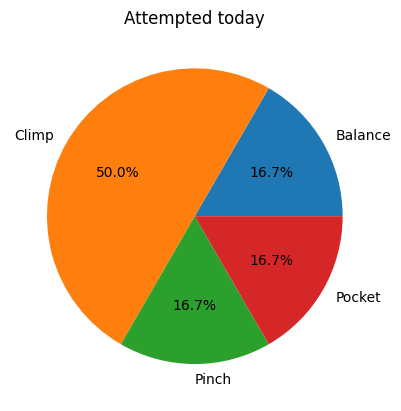

In [ ]:
# this returns a table format data with styles and number of climbs in each styles user attempted today 
def style_attempted(id):
    df = DataFrame()
    user_climbs = df.climbs_df[df.climbs_df['upload_author_id'] == id]
    user_climbs['date_logged'] = pd.to_datetime(user_climbs.date_logged).dt.date
    total_today = user_climbs[user_climbs.date_logged == datetime.now().date()]
    total_today = total_today.groupby('style').count()
    by_style = total_today[['id']]
    return by_style

    # plt.pie(
    #     by_style['id'],  # Values for the pie chart
    #     labels=by_style.index,  # Labels for each style
    #     autopct='%1.1f%%'  # Show percentages
    # )
    # plt.title('Attempted today')

style_attempted(3)

In [17]:
# this returns tabel formatted data frame for climbs attempted today by grade 
def grade_attempted(id):
    df = DataFrame()
    user_climbs = df.climbs_df[df.climbs_df['upload_author_id'] == id]
    user_climbs = user_climbs[user_climbs.completed == True]
    user_climbs['date_logged'] = pd.to_datetime(user_climbs.date_logged).dt.date
    total_today = user_climbs[user_climbs.date_logged == datetime.now().date()]
    filtered_total_today = total_today[['grade', 'attempt']]
    return filtered_total_today
    # print(filtered_total_today)
    # plt.bar(
    #     filtered_total_today['grade'],  # X-axis: grade values
    #     filtered_total_today['attempt']  # Y-axis: attempt values
    # )

    # # Add labels and title
    # plt.xlabel('Grade')  # Label for the x-axis
    # plt.ylabel('Number of Attempts')  # Label for the y-axis
    # plt.title('Grade Attempted today')  # Title of the chart
    # plt.xticks(ticks=filtered_total_today['grade'], labels=filtered_total_today['grade'])

    # # Display the chart
    # plt.show()
grade_attempted(3)

,grade,attempt
21,3,2
25,3,2
26,5,8
28,4,4
29,4,6
